In [1]:
### 1. IMPORT LIBRARIES ###

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Download NLTK stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))
print("Libraries loaded and stopwords ready.")




Libraries loaded and stopwords ready.


In [5]:
### 2. DATA LOADING AND PREPROCESSING ###

FILE_NAME = 'press_release_2004.csv'

try:
    # Using 'latin1' as 'Latin-1' might be case-sensitive
    df = pd.read_csv(FILE_NAME, encoding='latin1')
    print(f"Successfully loaded '{FILE_NAME}'.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: File '{FILE_NAME}' not found.")
    print("Please make sure the file is in the same directory as your notebook.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

# --- ADAPTED FOR YOUR CSV ---
TEXT_COLUMN_1 = 'pr_title'
TEXT_COLUMN_2 = 'pr_content'
LABEL_COLUMN = 'pr_issued_by'

if not {TEXT_COLUMN_1, TEXT_COLUMN_2, LABEL_COLUMN}.issubset(df.columns):
    print(f"ERROR: Your CSV must contain the columns: '{TEXT_COLUMN_1}', '{TEXT_COLUMN_2}', and '{LABEL_COLUMN}'")
    raise KeyError("Missing required columns")

df['text'] = df[TEXT_COLUMN_1].astype(str) + " " + df[TEXT_COLUMN_2].astype(str)
df = df[['text', LABEL_COLUMN]].dropna()
df.columns = ['text', 'ministry'] # Rename for simplicity

print(f"Total press releases to process: {len(df)}")

# Define text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-alphabetic chars
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # Remove stopwords
    return text

print("Cleaning text data...")
df['text_cleaned'] = df['text'].apply(clean_text)

# --- START: FIX FOR VALUEERROR ---
# We must remove classes with only one member before stratifying.
print(f"Original number of rows: {len(df)}")
ministry_counts = df['ministry'].value_counts()
# Get a list of ministries (classes) that appear 2 or more times
ministries_to_keep = ministry_counts[ministry_counts >= 2].index
# Filter the DataFrame to keep only these ministries
df = df[df['ministry'].isin(ministries_to_keep)]
print(f"Rows after removing single-instance classes: {len(df)}")
# --- END: FIX FOR VALUEERROR ---

# Encode labels
encoder = LabelEncoder()
df['ministry_encoded'] = encoder.fit_transform(df['ministry'])

# Get mapping for later
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
num_classes = len(label_mapping)
print(f"Total classes (ministries/issuers) with >= 2 samples: {num_classes}")

# Split data (stratify=y helps with imbalanced datasets)
X = df['text_cleaned']
y = df['ministry_encoded']

# Now this line will work
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Successfully loaded 'press_release_2004.csv'.
Dataset shape: (5254, 5)
Total press releases to process: 5254
Cleaning text data...
Original number of rows: 5254
Rows after removing single-instance classes: 5253
Total classes (ministries/issuers) with >= 2 samples: 58
Training samples: 4202, Test samples: 1051


In [7]:
### 3. MODEL 1: RANDOM FOREST + TF-IDF ###

print("\n--- Training Model 1: Random Forest ---")

# 1. Vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
print("Fitting TF-IDF vectorizer...")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("Vectorization complete.")

# 2. Compute Class Weights for imbalance
class_weights_ml = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict_ml = {i: weight for i, weight in enumerate(class_weights_ml)}

# 3. Model Training
print("Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight=class_weights_dict_ml,
    n_jobs=-1  # Use all available CPU cores
)
rf_model.fit(X_train_tfidf, y_train)
print("Random Forest training complete.")

# 4. Evaluation
y_pred_rf = rf_model.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\nRandom Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest F1-Score (Weighted): {f1_rf:.4f}\n")
print("--- Random Forest Classification Report ---")

# --- THIS IS THE FIX ---
# We provide the 'labels' parameter to tell the report
# to include ALL 58 classes, even if some aren't in y_test.
# np.arange(num_classes) creates the list [0, 1, 2, ..., 57]
labels_for_report = np.arange(num_classes)

print(classification_report(
    y_test, 
    y_pred_rf, 
    labels=labels_for_report,  # <-- ADDED THIS LINE
    target_names=encoder.classes_, 
    zero_division=0
))
# -----------------------


--- Training Model 1: Random Forest ---
Fitting TF-IDF vectorizer...
Vectorization complete.
Training Random Forest model...
Random Forest training complete.

Random Forest Accuracy: 0.8696
Random Forest F1-Score (Weighted): 0.8669

--- Random Forest Classification Report ---
                                                          precision    recall  f1-score   support

                                                 Cabinet       1.00      0.86      0.92         7
            Cabinet Committee on Economic Affairs (CCEA)       0.57      0.80      0.67         5
                         Department of Ocean Development       0.00      0.00      0.00         1
                                     Department of Space       0.00      0.00      0.00         0
                                     Election Commission       0.96      0.96      0.96        23
           Ministry for Development of North-East Region       0.71      0.83      0.77         6
                                 Mi

In [9]:
### 4. MODEL 2: 1D CONVOLUTIONAL NEURAL NETWORK (CNN) ###

print("\n--- Training Model 2: 1D CNN ---")

# 1. Tokenization & Padding
VOCAB_SIZE = 20000  # Max number of unique words to use
MAX_LEN = 250       # Max length of sequences
EMBEDDING_DIM = 100 # Dimension of word vectors

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>') # <OOV> for out-of-vocabulary words
tokenizer.fit_on_texts(X_train)

print("Tokenizing and padding sequences...")
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN, truncating='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN, truncating='post')

# 2. One-hot encode labels for categorical_crossentropy
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)
print("Sequencing complete.")

# 3. Compute Class Weights (for Keras)
class_weights_dl = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict_dl = {i: weight for i, weight in enumerate(class_weights_dl)}

# 4. Build Model
print("Building 1D CNN model...")
cnn_model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # Softmax for multi-class classification
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(cnn_model.summary())

# 5. Model Training
EPOCHS = 5
BATCH_SIZE = 64

print(f"Training 1D CNN for {EPOCHS} epochs...")
history = cnn_model.fit(
    X_train_seq,
    y_train_cat,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,  # Use 10% of training data for validation
    class_weight=class_weights_dict_dl
)
print("CNN training complete.")

# 6. Evaluation
# Get probability distribution
y_pred_probs_cnn = cnn_model.predict(X_test_seq)
# Get the class with the highest probability
y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)

accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

print(f"\n1D CNN Accuracy: {accuracy_cnn:.4f}")
print(f"1D CNN F1-Score (Weighted): {f1_cnn:.4f}\n")
print("--- 1D CNN Classification Report ---")

# --- THIS IS THE FIX ---
# We provide the 'labels' parameter to tell the report
# to include ALL 58 classes, even if some aren't in y_test.
labels_for_report = np.arange(num_classes) 

print(classification_report(
    y_test, 
    y_pred_cnn, 
    labels=labels_for_report,  # <-- ADDED THIS LINE
    target_names=encoder.classes_, 
    zero_division=0
))
# -----------------------


--- Training Model 2: 1D CNN ---
Tokenizing and padding sequences...
Sequencing complete.
Building 1D CNN model...


d:\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Training 1D CNN for 5 epochs...
Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0205 - loss: 4.1970 - val_accuracy: 0.1045 - val_loss: 4.0392
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.0405 - loss: 4.0006 - val_accuracy: 0.2019 - val_loss: 3.9927
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1041 - loss: 3.9229 - val_accuracy: 0.2589 - val_loss: 3.8261
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2090 - loss: 3.6010 - val_accuracy: 0.4014 - val_loss: 3.3937
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2971 - loss: 3.2448 - val_accuracy: 0.5582 - val_loss: 2.7109
CNN training complete.
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

1D CNN Accuracy: 0.5728
1D CNN F1-Score (Weighted): 0.5797

--- 1D CNN Classification Report ---
                                                          precision    recall  f1-score   support

                                                 Cabinet       0.32      0


--- Comparative Analysis ---
| Model         |   Accuracy |   F1-Score (Weighted) |
|:--------------|-----------:|----------------------:|
| Random Forest |   0.869648 |              0.866893 |
| 1D CNN        |   0.572788 |              0.579749 |

Plotting CNN training history...


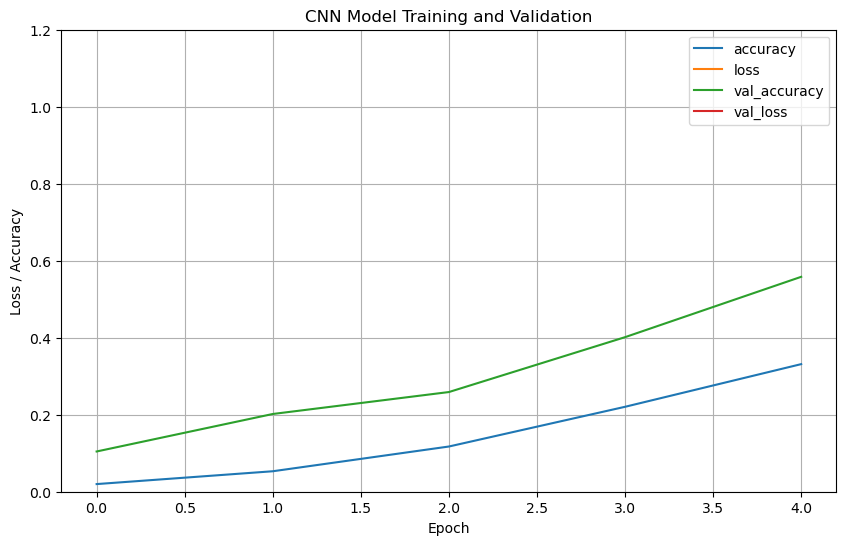

Plotting Confusion Matrix for 1D CNN model...


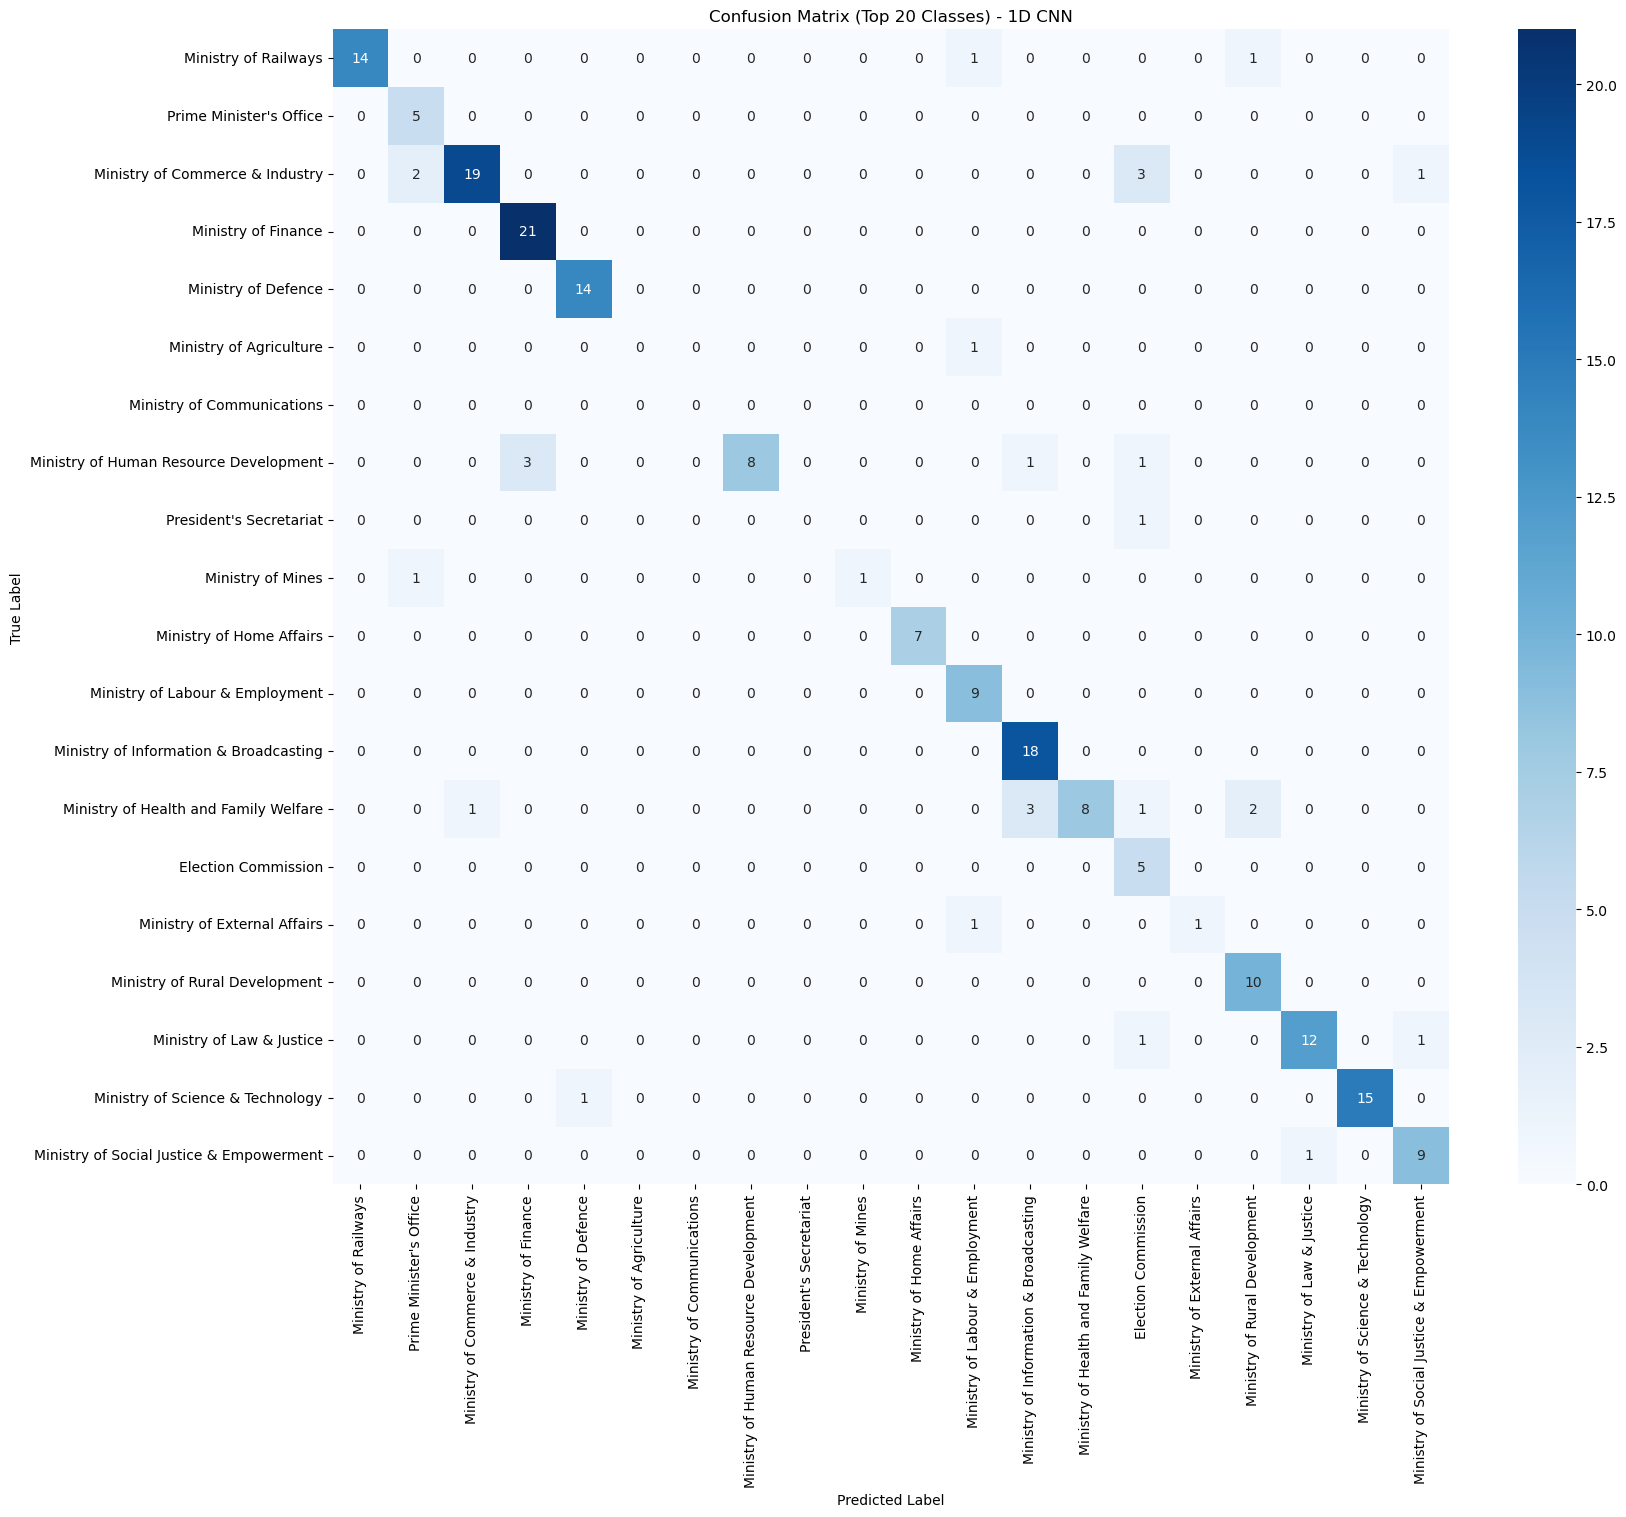


--- Project Complete---


In [10]:
### 5. COMPARATIVE ANALYSIS & VISUALIZATION ###

print("\n--- Comparative Analysis ---")

# Data for comparison table
results = {
    'Model': ['Random Forest', '1D CNN'],
    'Accuracy': [accuracy_rf, accuracy_cnn],
    'F1-Score (Weighted)': [f1_rf, f1_cnn]
}
results_df = pd.DataFrame(results)

print(results_df.to_markdown(index=False))


# Plotting CNN training history
print("\nPlotting CNN training history...")
try:
    pd.DataFrame(history.history).plot(figsize=(10, 6))
    plt.title("CNN Model Training and Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss / Accuracy")
    plt.ylim(0, 1.2) # Set y-limit for better readability
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Could not plot history: {e}")

# Plotting Confusion Matrix for the better model (CNN)
print("Plotting Confusion Matrix for 1D CNN model...")
try:
    cm = confusion_matrix(y_test, y_pred_cnn)
    
    # Get top 20 most frequent classes for a cleaner plot
    top_n = 20
    top_classes_names = df['ministry'].value_counts().index[:top_n]
    top_classes_indices = [encoder.transform([name])[0] for name in top_classes_names if name in encoder.classes_]
    
    # Filter matrix to only include top N classes
    cm_filtered = cm[top_classes_indices, :][:, top_classes_indices]
    labels_filtered = [name for name in top_classes_names if name in encoder.classes_]

    plt.figure(figsize=(18, 15))
    sns.heatmap(cm_filtered, annot=True, fmt='d', 
                xticklabels=labels_filtered, yticklabels=labels_filtered, cmap='Blues')
    plt.title(f'Confusion Matrix (Top {len(labels_filtered)} Classes) - 1D CNN')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

except Exception as e:
    print(f"Could not plot confusion matrix: {e}")

print("\n--- Project Complete---")

In [11]:
### 6. PREDICTION ON NEW, UNSEEN TEXT ###

# --- Define two new example press releases ---

text_example_1 = """
The Defence Minister announced a new procurement of 50 advanced fighter jets
to strengthen our air force. This deal will also involve technology transfer
to promote 'Make in India'. The armed forces are always ready to protect our borders.
"""

text_example_2 = """
The Reserve Bank of India (RBI) today announced that it will keep the
repo rate unchanged at 4%. The governor cited inflationary pressures
and global market uncertainty as key factors in the monetary policy decision.
"""

# --- Create a reusable prediction function ---

def predict_ministry(text_input):
    """
    Takes a raw text string and predicts its ministry using
    both the Random Forest and 1D CNN models.
    """
    print("="*50)
    print(f"Predicting for text: \n\"{text_input[:100]}...\"\n")
    
    # 1. Clean the new text using the *exact same* function
    cleaned_text = clean_text(text_input)
    
    
    # --- MODEL 1: RANDOM FOREST PREDICTION ---
    print("--- Model 1: Random Forest ---")
    
    # 2. Vectorize the cleaned text using the *fitted* vectorizer
    text_tfidf = vectorizer.transform([cleaned_text])
    
    # 3. Predict the class
    rf_pred_numeric = rf_model.predict(text_tfidf)
    
    # 4. Inverse-transform the numeric label to its name
    rf_pred_label = encoder.inverse_transform(rf_pred_numeric)
    print(f"Prediction: ==> {rf_pred_label[0]}")
    
    
    # --- MODEL 2: 1D CNN PREDICTION ---
    print("\n--- Model 2: 1D CNN ---")
    
    # 2. Tokenize the cleaned text using the *fitted* tokenizer
    text_seq = tokenizer.texts_to_sequences([cleaned_text])
    
    # 3. Pad the sequence to MAX_LEN
    text_padded = pad_sequences(text_seq, maxlen=MAX_LEN, truncating='post')
    
    # 4. Predict probabilities for all classes
    cnn_pred_probs = cnn_model.predict(text_padded)
    
    # 5. Get the index (class) with the highest probability
    cnn_pred_numeric = np.argmax(cnn_pred_probs, axis=1)
    
    # 6. Inverse-transform the numeric label to its name
    cnn_pred_label = encoder.inverse_transform(cnn_pred_numeric)
    print(f"Prediction: ==> {cnn_pred_label[0]}")
    
    # (Optional) Show top 3 probabilities
    print("\nTop 3 CNN Probabilities:")
    top_3_indices = np.argsort(cnn_pred_probs[0])[-3:][::-1]
    top_3_labels = encoder.inverse_transform(top_3_indices)
    top_3_probs = cnn_pred_probs[0][top_3_indices]
    
    for label, prob in zip(top_3_labels, top_3_probs):
        print(f"  - {label}: {prob*100:.2f}%")
    print("="*50)

# --- Run the predictions ---
predict_ministry(text_example_1)
predict_ministry(text_example_2)

# --- You can also try your own text ---
# my_text = "Your custom text here"
# predict_ministry(my_text)

Predicting for text: 
"
The Defence Minister announced a new procurement of 50 advanced fighter jets
to strengthen our air ..."

--- Model 1: Random Forest ---
Prediction: ==> Ministry of Defence

--- Model 2: 1D CNN ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: ==> Ministry of Heavy Industries & Public Enterprises

Top 3 CNN Probabilities:
  - Ministry of Heavy Industries & Public Enterprises: 2.69%
  - Ministry of Housing & Urban Affairs: 2.59%
  - Ministry of Textiles: 2.19%
Predicting for text: 
"
The Reserve Bank of India (RBI) today announced that it will keep the
repo rate unchanged at 4%. Th..."

--- Model 1: Random Forest ---
Prediction: ==> Ministry of Finance

--- Model 2: 1D CNN ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: ==> Cabinet

Top 3 CNN Probabilities:
  - Cabinet: 2.40%
  - Ministry of Textiles: 2.16%
  - Cabinet Committee on Economic Affairs (CCEA): 2.13%
